First, let's get out python imports out of the way.

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sinc
from scipy.signal.windows import kaiser
from scipy import signal
from math import ceil

Let's define a function that will build our sinc table for us. The sinc table will only contain the "right wing" of the symmetric FIR filter. This function will also return a table of differences between successive FIR sample which will be useful to speed up our linear interpolation latter on.

In [78]:
def build_sinc_table(num_zeros, samples_per_crossing):

    SINC_SIZE_ = num_zeros * samples_per_crossing
    KAISER_BETA = 10

    x = np.linspace(-num_zeros, num_zeros, SINC_SIZE_ * 2 + 1)
    y = sinc(x)

    window = kaiser(len(y), KAISER_BETA)

    y = np.multiply(y, window)

    h = y[SINC_SIZE_:]

    h_diff = np.subtract(h[1:], h[:-1])
    h_diff = np.append(h_diff, 0)

    return h, h_diff

And here's what our table looks like:

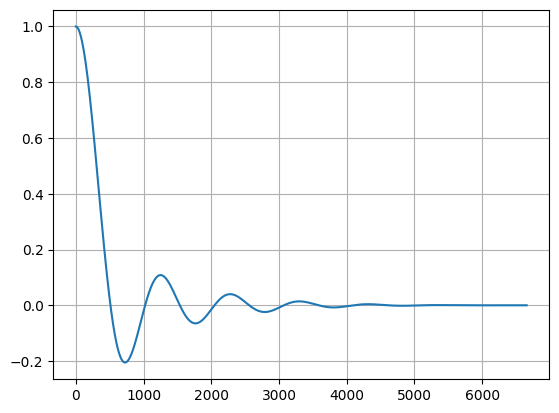

In [79]:
h, h_diff = build_sinc_table(num_zeros=13, samples_per_crossing=512)
plt.figure(1)
plt.plot(h)
plt.grid()

We can now implement the main algorithm as described [here](https://ccrma.stanford.edu/~jos/resample/Implementation.html). 

In [80]:
def sinc_resample(x, ratio, h, h_diff, samples_per_crossing):
    time_step = 1 / ratio
    filter_scale = min(1, ratio)
    filter_step = samples_per_crossing * filter_scale

    output = np.ndarray(shape=ceil(len(x) * ratio))
    out_idx = 0
    t = 0
    while t < len(x):

        acc = 0

        integer_part = int(t)
        fractional_part = t - integer_part

        # Compute left wing
        filter_offset = filter_step * fractional_part

        left_coeff_count = int((len(h) - filter_offset) / filter_step)
        left_coeff_count = min(integer_part, left_coeff_count) # avoid underflow access
        for i in range(-left_coeff_count, 1):
            filter_idx = filter_offset + filter_step * abs(i)
            fraction = filter_idx - int(filter_idx)
            filter_idx = int(filter_idx)

            weight = h[filter_idx] + fraction * h_diff[filter_idx]
            acc += x[integer_part + i] * weight

        # compute right wing
        fractional_part = 1 - fractional_part
        filter_offset = filter_step * fractional_part

        right_coeff_count = int((len(h) - filter_offset) / filter_step)
        right_coeff_count = min(len(x) - integer_part - 1, right_coeff_count) # avoid overflow access
        for i in range(0, right_coeff_count):
            filter_idx = filter_offset + filter_step * i
            fraction = filter_idx - int(filter_idx)
            filter_idx = int(filter_idx)

            weight = h[filter_idx] + fraction * h_diff[filter_idx]
            acc += x[integer_part + 1 + i] * weight

        if out_idx < len(output):
            output[out_idx] = acc
            out_idx += 1
        t += time_step

    return output


Here's an example of the implementation at work where we will upsample a simple sine wave. The blue dotted line on the graph effectively shows what we would have obtained using a linear interpolation method instead.

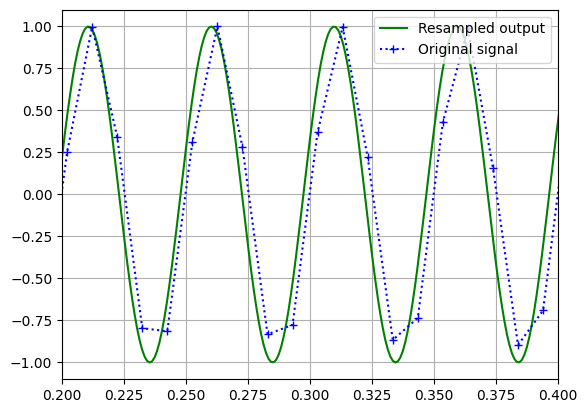

In [84]:
# Number of zeros crossing
NZ = 13

# Number of samples per zero crossing.
# Higher sample count means better precision for our interpolation at the cost of more memory usage.
SAMPLES_PER_CROSSING = 128
h, h_diff = build_sinc_table(NZ, SAMPLES_PER_CROSSING)

ORIGINAL_FS = 100
SIGNAL_FREQUENCY = 20
TARGET_FS = 1000

time = np.linspace(0, 1, ORIGINAL_FS)
in_sine = np.sin(2 * np.pi * time * SIGNAL_FREQUENCY)

output = sinc_resample(in_sine, TARGET_FS / ORIGINAL_FS, h, h_diff, SAMPLES_PER_CROSSING)
out_time = np.linspace(0, 1, TARGET_FS)
plt.plot(out_time, output, 'g', label="Resampled output")
plt.plot(time, in_sine, 'b+:', label="Original signal")
plt.xlim(0.2, 0.4)
plt.ylim(-1.1, 1.1)
plt.grid()
plt.legend(loc="upper right")
plt.show()

We are now ready to perform our own benchmark test. Inspired by the [Infinite Wave](https://src.infinitewave.ca/) methodology, we will try to downsample a quadratic chirp signal from 96kHz to 44.1kHz.

In [82]:

ORIGINAL_FS = 96000
CHIRP_LENGTH_SECONDS = 8
END_CHIRP_FREQUENCY = 44000

time = np.linspace(0, CHIRP_LENGTH_SECONDS, ORIGINAL_FS*CHIRP_LENGTH_SECONDS)
in_chirp = signal.chirp(time, 0, CHIRP_LENGTH_SECONDS, END_CHIRP_FREQUENCY, 'quadratic') * 0.6


We will now resample that signal 3 different ways. First, we'll use our `sinc_resample` method with a sinc table containing 13 zero crossing and then again with a table containing 32 zero crossing. This should allow us to see how the number of zero crossing in our table affects the lowpass filtering of our implementation. Lastly, we will use numpy to resample the signal using linear interpolation so that we can compare our algorithm against a fast a common resampling method.

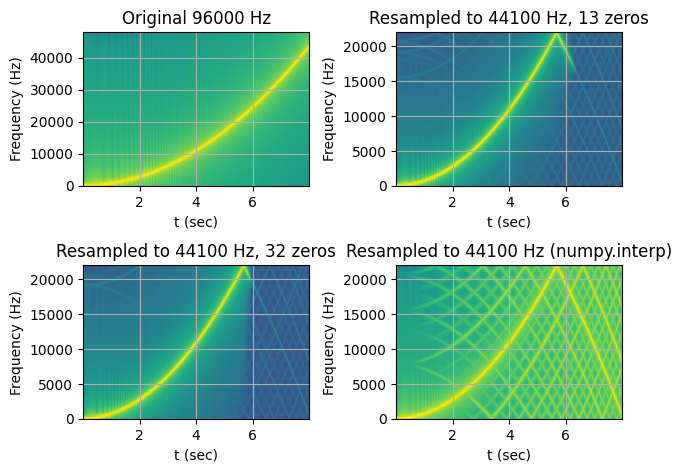

In [83]:
TARGET_FS = 44100
RESAMPLING_RATIO = TARGET_FS / ORIGINAL_FS

nz_1 = 13
SAMPLES_PER_CROSSING = 512
h, h_diff = build_sinc_table(nz_1, SAMPLES_PER_CROSSING)

out_sinc_1 = sinc_resample(
    in_chirp,
    RESAMPLING_RATIO,
    h,
    h_diff,
    SAMPLES_PER_CROSSING)

nz_2 = 32
SAMPLES_PER_CROSSING = 512
h, h_diff = build_sinc_table(nz_2, SAMPLES_PER_CROSSING)

out_sinc_2 = sinc_resample(
    in_chirp,
    RESAMPLING_RATIO,
    h,
    h_diff,
    SAMPLES_PER_CROSSING)

out_time = np.linspace(0, CHIRP_LENGTH_SECONDS, TARGET_FS*CHIRP_LENGTH_SECONDS)
out_linear = np.interp(out_time, time, in_chirp)

def plot_spectrogram(title, w, fs, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
    plt.specgram(w, Fs=fs, mode='magnitude')
    ax.set_title(title)
    ax.set_xlabel('t (sec)')
    ax.set_ylabel('Frequency (Hz)')
    ax.grid(True)

fig = plt.figure(1)
ax1 = plt.subplot(221)
plot_spectrogram(f"Original {ORIGINAL_FS} Hz", in_chirp, ORIGINAL_FS, ax1)
ax2 = plt.subplot(222)
plot_spectrogram(f"Resampled to {TARGET_FS} Hz, {nz_1} zeros", out_sinc_1, TARGET_FS, ax2)
ax2 = plt.subplot(223)
plot_spectrogram(f"Resampled to {TARGET_FS} Hz, {nz_2} zeros", out_sinc_2, TARGET_FS, ax2)
ax3 = plt.subplot(224)
plot_spectrogram(f"Resampled to {TARGET_FS} Hz (numpy.interp)", out_linear, TARGET_FS, ax3)
fig.tight_layout(pad=1.0)
plt.show()